# **Movielens Dataset**

# **Collaborative Filtering Model**

## **Installing** **packages**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset, info = tfds.load('movielens/100k-ratings', split='train', with_info=True)
movies, movies_info = tfds.load('movielens/100k-movies', split='train', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.SNAKAE_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.8VH3LB_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


## **Inspect and Preprocess the Data**

In [ ]:
# Convert the datasets to DataFrames
ratings = tfds.as_dataframe(dataset)
movies_df = tfds.as_dataframe(movies)

# Display basic information about the datasets
print(ratings.head())
print(movies_df.head())


   bucketized_user_age movie_genres movie_id  \
0                 45.0          [7]   b'357'   
1                 25.0      [4, 14]   b'709'   
2                 18.0          [4]   b'412'   
3                 50.0       [5, 7]    b'56'   
4                 50.0     [10, 16]   b'895'   

                                 movie_title  raw_user_age  timestamp  \
0  b"One Flew Over the Cuckoo's Nest (1975)"          46.0  879024327   
1                b'Strictly Ballroom (1992)'          32.0  875654590   
2             b'Very Brady Sequel, A (1996)'          24.0  882075110   
3                     b'Pulp Fiction (1994)'          50.0  883326919   
4                         b'Scream 2 (1997)'          55.0  891409199   

   user_gender user_id  user_occupation_label user_occupation_text  \
0         True  b'138'                      4            b'doctor'   
1         True   b'92'                      5     b'entertainment'   
2         True  b'301'                     17           b'stud

## **Data Cleaning and Transformation**

In [ ]:
# Clean and preprocess the ratings DataFrame
ratings_df = ratings[['user_id', 'movie_id', 'user_rating']].copy()
ratings_df.columns = ['userId', 'movieId', 'rating']

# Clean and preprocess the movies DataFrame
movies_df = movies_df[['movie_id', 'movie_title']].copy()
movies_df.columns = ['movieId', 'title']

# Merge the ratings and movies data
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Display the first few rows of the merged DataFrame
print(merged_df.head())


   userId movieId  rating                                      title
0  b'138'  b'357'     4.0  b"One Flew Over the Cuckoo's Nest (1975)"
1   b'16'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"
2  b'429'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"
3  b'316'  b'357'     4.0  b"One Flew Over the Cuckoo's Nest (1975)"
4  b'815'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"


## **Exploratory Data Analysis (EDA)**

### **Distribution of Ratings**

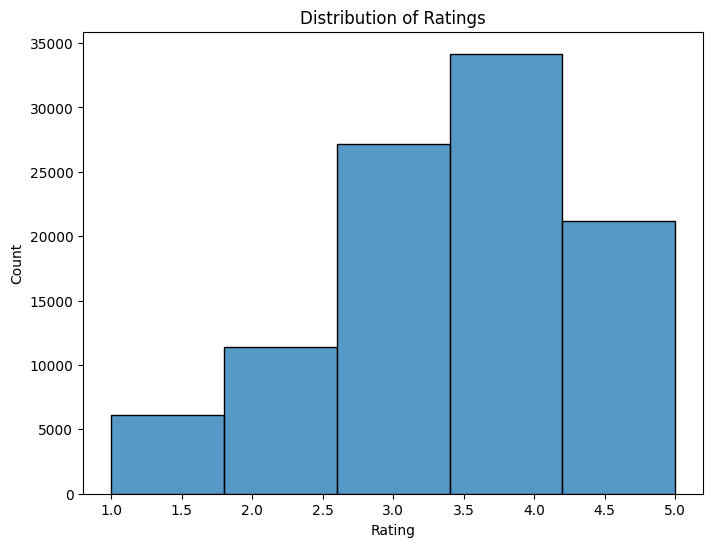

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(merged_df['rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### **Number of Ratings per Movie**

<ipython-input-7-088436dbbfe8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=movie_ratings.values, y=movie_ratings.index, palette='viridis')


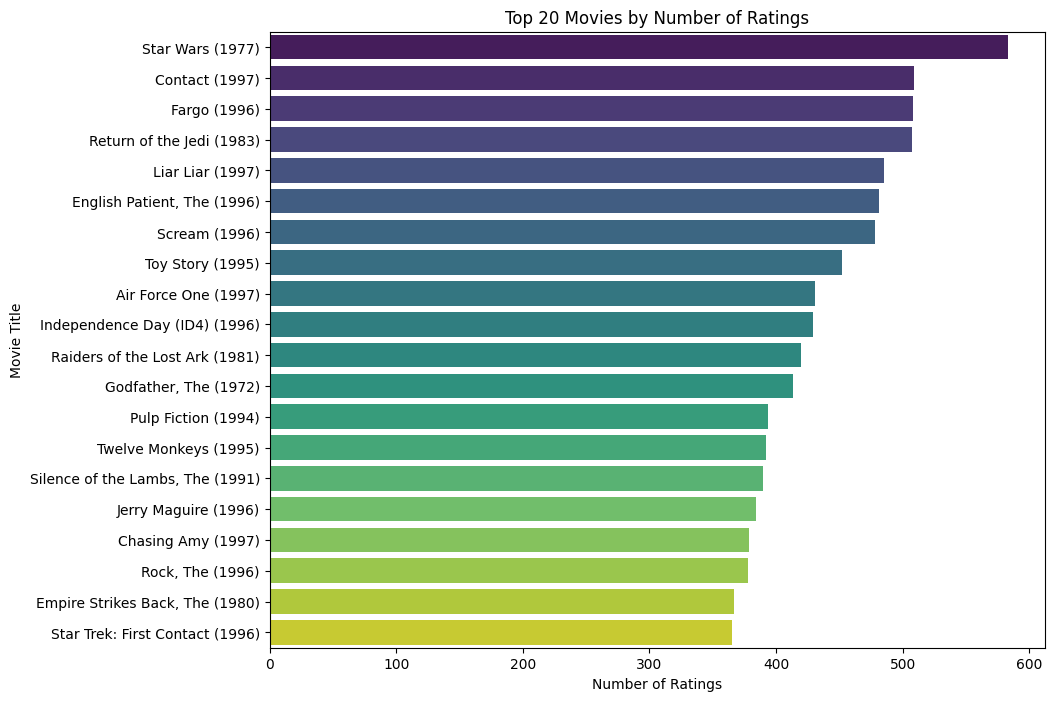

In [ ]:
# Plot the number of ratings per movie
movie_ratings = merged_df.groupby('title')['rating'].count().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x=movie_ratings.values, y=movie_ratings.index, palette='viridis')
plt.title('Top 20 Movies by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


### ** Average Rating per Movie**

<ipython-input-8-bb257ce535fb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_ratings.values, y=average_ratings.index, palette='viridis')


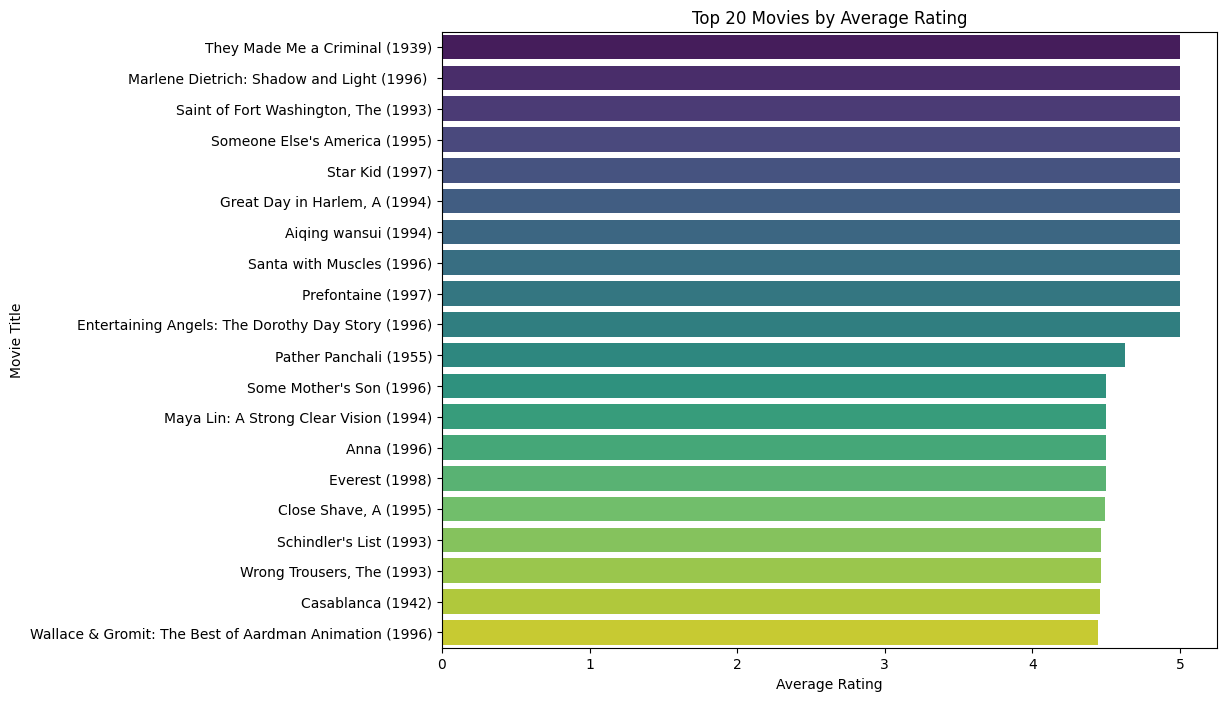

In [ ]:
# Plot the average rating per movie
average_ratings = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x=average_ratings.values, y=average_ratings.index, palette='viridis')
plt.title('Top 20 Movies by Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()


## **Encode Users and Movies**

In [ ]:
# Create user and movie data encoders
user_ids = merged_df['userId'].unique().tolist()
movie_ids = merged_df['movieId'].unique().tolist()

user_to_index = {x: i for i, x in enumerate(user_ids)}
movie_to_index = {x: i for i, x in enumerate(movie_ids)}

# Map users and movies to their respective indices
merged_df['user'] = merged_df['userId'].map(user_to_index)
merged_df['movie'] = merged_df['movieId'].map(movie_to_index)

# Inspect the first few rows
print(merged_df.head())


   userId movieId  rating                                      title  user  \
0  b'138'  b'357'     4.0  b"One Flew Over the Cuckoo's Nest (1975)"     0   
1   b'16'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"     1   
2  b'429'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"     2   
3  b'316'  b'357'     4.0  b"One Flew Over the Cuckoo's Nest (1975)"     3   
4  b'815'  b'357'     5.0  b"One Flew Over the Cuckoo's Nest (1975)"     4   

   movie  
0      0  
1      0  
2      0  
3      0  
4      0  


## **Create Training and Validation Sets**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

# Inspect the shapes of the train and test sets
print(train.shape, test.shape)


(80000, 6) (20000, 6)


## **Define the Model**

In [ ]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size):
        super(RecommenderNet, self).__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.movie_embedding = tf.keras.layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.movie_bias = tf.keras.layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 50

model = RecommenderNet(num_users, num_movies, embedding_size)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.001)
)


## **Train the Model**

In [ ]:
# Prepare the data for the model
train_data = tf.data.Dataset.from_tensor_slices((train[['user', 'movie']].values, train['rating'].values))
train_data = train_data.shuffle(100000).batch(512)

val_data = tf.data.Dataset.from_tensor_slices((test[['user', 'movie']].values, test['rating'].values))
val_data = val_data.batch(512)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


Epoch 1/5
157/157 [==============================] - 15s 78ms/step - loss: -3.8649 - val_loss: -23.5530
Epoch 2/5
157/157 [==============================] - 3s 18ms/step - loss: -336.5868 - val_loss: -1110.0411
Epoch 3/5
157/157 [==============================] - 3s 19ms/step - loss: -3343.7412 - val_loss: -6412.3154
Epoch 4/5
157/157 [==============================] - 2s 11ms/step - loss: -10964.7852 - val_loss: -16158.1348
Epoch 5/5
157/157 [==============================] - 2s 9ms/step - loss: -22636.4824 - val_loss: -29479.5996


## **Visualize Training History**

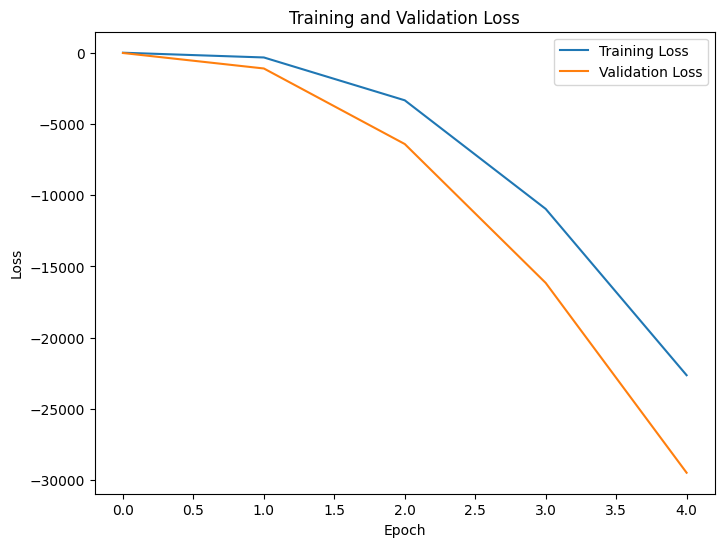

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## **Make Predictions**

In [ ]:
def predict(user_id, movie_id):
    user_index = user_to_index[user_id]
    movie_index = movie_to_index[movie_id]
    pred = model.predict(np.array([[user_index, movie_index]]))
    return pred

# Predict the rating for a given user and movie
user_id = user_ids[0]
movie_id = movie_ids[0]
predicted_rating = predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id} is {predicted_rating}")


1/1 [==============================] - 0s 219ms/step
Predicted rating for user b'138' and movie b'357' is [[1.]]


## **Evaluate the Model**

### **Prepare the Test Data for Batch Prediction**


In [ ]:
# Prepare the test data for batch prediction
test_user_movie_array = np.array([[user_to_index[row.userId], movie_to_index[row.movieId]] for row in test.itertuples()])



### ** Predict the Ratings in Batches**

In [ ]:
# Predict the ratings for the test set in batches
batch_size = 512
num_batches = int(np.ceil(len(test_user_movie_array) / batch_size))

predictions = []

for batch_num in range(num_batches):
    batch_start = batch_num * batch_size
    batch_end = min((batch_num + 1) * batch_size, len(test_user_movie_array))
    batch_data = test_user_movie_array[batch_start:batch_end]
    batch_predictions = model.predict(batch_data)
    predictions.extend(batch_predictions)


1/1 [==============================] - 0s 17ms/step


### **Compute the RMSE**

In [ ]:
# Convert the predictions to a numpy array
predictions = np.array(predictions).flatten()

# Calculate RMSE
y_true = test['rating'].values
rmse = mean_squared_error(y_true, predictions, squared=False)
print(f"Test RMSE: {rmse}")


Test RMSE: 2.76863694190979


## ** Softmax Deep Neural Network Model**

## **Data Loading and Preprocessing**

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip



--2024-07-04 14:39:55--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  2.83MB/s    in 1.7s    

2024-07-04 14:39:57 (2.83 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))


Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [ ]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
print(ratings_dataset.head())
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

   user id  movie id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


from matplotlib import pyplot as plt
_df_0['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [ ]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [ ]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


from matplotlib import pyplot as plt
_df_6['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['movie'].plot(kind='hist', bins=20, title='movie')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='rating', y='movie', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user'}, axis=1)
              .sort_values('user', ascending=True))
  xs = counted['user']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_14['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['movie'].plot(kind='line', figsize=(8, 4), title='movie')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='movie', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

In [ ]:
n_factors = 150

In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

In [ ]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## **Softmax Deep Neural Network Model**

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
m = tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 150)               141450    ['input_3[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 150)               249600    ['input_4[0][0]']             
                                                                                              

## **Training & Evaluating**

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/70
701/701 [==============================] - 7s 4ms/step - loss: 0.8105 - accuracy: 0.0608 - val_loss: 0.5279 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 3s 4ms/step - loss: 0.5365 - accuracy: 0.0610 - val_loss: 0.5144 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 3s 4ms/step - loss: 0.5282 - accuracy: 0.0609 - val_loss: 0.5115 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 4s 5ms/step - loss: 0.5242 - accuracy: 0.0609 - val_loss: 0.5106 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 3s 4ms/step - loss: 0.5221 - accuracy: 0.0609 - val_loss: 0.5093 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 3s 4ms/step - loss: 0.5206 - accuracy: 0.0609 - val_loss: 0.5084 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 3s 4ms/step - lo

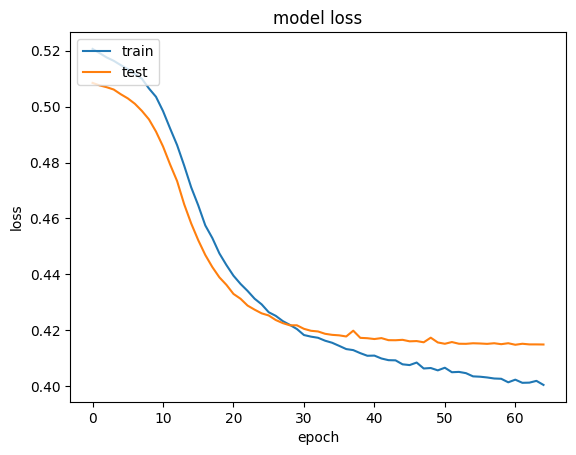

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


from matplotlib import pyplot as plt
_df_18['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['movie'].plot(kind='hist', bins=20, title='movie')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_20.groupby('movie title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='rating', y='movie', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user id']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_22.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user id'}, axis=1)
              .sort_values('user id', ascending=True))
  xs = counted['user id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('user id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user id')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['user']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['user']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'user'}, axis=1)
              .sort_values('user', ascending=True))
  xs = counted['user']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('user', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('movie title')):
  _plot_series(series, series_name, i)
  fig.legend(title='movie title', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('user')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_26['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_27['movie'].plot(kind='line', figsize=(8, 4), title='movie')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_28['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_28, x='rating', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['movie title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='movie', y='movie title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138]),
 array([1152,  389,  302, ..., 1588,  399,  612])]

In [ ]:
user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[7, 55, 87, 113, 313, 337, 389, 390, 399, 411, 432, 460, 498, 528, 580, 604, 612, 643, 666, 783, 996, 1005, 1032, 1102, 1132, 1157, 1190, 1208, 1251, 1260, 1284, 1302, 1342, 1523, 1558, 1615]


In [ ]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

In [ ]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

In [ ]:
len(unseen_movies) + len(seen_movies)

1664

In [ ]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1628)

In [ ]:
predicted_ratings = model.predict(model_input)

51/51 [==============================] - 0s 2ms/step


In [ ]:
print(predicted_ratings.shape)

(1628, 9)


In [ ]:
print(predicted_ratings)

[[7.76988566e-01 2.22910598e-01 5.98627139e-06 ... 1.17657610e-05
  9.65941308e-06 1.86827201e-05]
 [6.90811276e-01 3.09067667e-01 7.05510911e-06 ... 1.39486165e-05
  1.14751110e-05 2.50686553e-05]
 [9.14705813e-01 8.52537379e-02 2.30773571e-06 ... 4.44181251e-06
  4.17721549e-06 6.65973312e-06]
 ...
 [5.61570346e-01 4.38239276e-01 1.09667944e-05 ... 2.26323718e-05
  1.73978788e-05 4.11284382e-05]
 [5.93224943e-01 4.06607926e-01 9.73425995e-06 ... 2.04031730e-05
  1.51322047e-05 3.48204521e-05]
 [6.33617342e-01 3.66115898e-01 1.72622022e-05 ... 3.34440047e-05
  2.63612819e-05 5.32954036e-05]]


In [ ]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.77698857, 0.6908113 , 0.9147058 , ..., 0.56157035, 0.59322494,
       0.63361734], dtype=float32)

In [ ]:
predicted_ratings.shape

(1628,)

In [ ]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[ 962  738  135 ...  703 1588   29]


In [ ]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies


array(['Meet Wally Sparks (1997)', 'In the Line of Duty 2 (1987)',
       'Baton Rouge (1988)', ..., 'House Arrest (1996)', 'Volcano (1997)',
       'Age of Innocence, The (1993)'], dtype=object)

In [ ]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Meet Wally Sparks (1997)',
 'In the Line of Duty 2 (1987)',
 'Baton Rouge (1988)',
 'Sword in the Stone, The (1963)',
 'Conspiracy Theory (1997)',
 'Striking Distance (1993)',
 'Getaway, The (1994)',
 'Saint, The (1997)',
 'Red Firecracker, Green Firecracker (1994)',
 'Phat Beach (1996)',
 'Two or Three Things I Know About Her (1966)',
 "Dante's Peak (1997)",
 'Jaws 3-D (1983)',
 'Diva (1981)',
 'Good Will Hunting (1997)',
 'Mina Tannenbaum (1994)',
 'Sudden Manhattan (1996)',
 'Transformers: The Movie, The (1986)',
 'Double Happiness (1994)',
 'Jaws 2 (1978)']


In [ ]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [ ]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
35
Enter number of movies to be recommended:
6

Movie seen by the User:
['Air Bud (1997)',
 'Air Force One (1997)',
 'Conspiracy Theory (1997)',
 'Contact (1997)',
 'Cop Land (1997)',
 'Excess Baggage (1997)',
 'Fire Down Below (1997)',
 'G.I. Jane (1997)',
 'Game, The (1997)',
 'George of the Jungle (1997)',
 'Jungle2Jungle (1997)',
 'Kiss the Girls (1997)',
 'Kolya (1996)',
 'Kull the Conqueror (1997)',
 'Mimic (1997)',
 'Money Talks (1997)',
 'Mother (1996)',
 'Murder at 1600 (1997)',
 'Peacemaker, The (1997)',
 'Saint, The (1997)',
 'Spawn (1997)',
 'Thousand Acres, A (1997)',
 'Volcano (1997)']

52/52 [==============================] - 0s 3ms/step
---------------------------------------------------------------------------------
Top 6 Movie recommendations for the User 35 are:
['Beans of Egypt, Maine, The (1994)',
 'Indiana Jones and the Last Crusade (1989)',
 'Jaws (1975)',
 'Contempt (Mépris, Le) (1963)',
 'Men of Means (1998)',
 'Ghost in the Shell (Kokaku kidotai)